In [1]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from unet import unet_model
import random
from pathlib import Path
import logging
LOGGER = logging.getLogger()
from datetime import datetime

from skimage.morphology import binary_erosion
from skimage.morphology import skeletonize

from skimage.morphology import label
from skimage.measure import regionprops
from skimage.color import label2rgb

import perovskite_flattening as perov_flatten

 -- images --
['.DS_Store', 'task-20-20230207_Me4_NPs_perov_1um.0_00009.spm_training.png', 'task-21-20230207_Me4_NPs_perov_5um.0_00006.spm_training.png', 'task-22-20230207_Me4_NPs_perov_10um.0_00007.spm_training.png', 'task-23-20230207_MeO_NPs_perov_1um.0_00005.spm_training.png', 'task-24-20230207_MeO_NPs_perov_5um.0_00003.spm_training.png', 'task-25-20230207_MeO_NPs_perov_10um.0_00004.spm_training.png', 'task-26-20230207_MeO_perov_1um.0_00002.spm_training.png', 'task-27-20230207_MeO_perov_5um.0_0000.spm_training.png']
.DS_Store
task-20-20230207_Me4_NPs_perov_1um.0_00009.spm_training.png


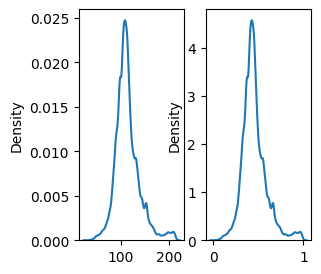

image min: 0.0 image max: 1.0
task-21-20230207_Me4_NPs_perov_5um.0_00006.spm_training.png


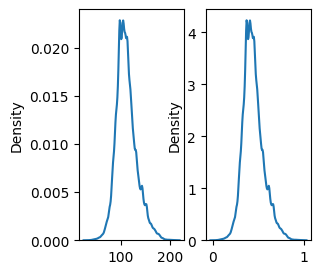

image min: 0.0 image max: 1.0
task-22-20230207_Me4_NPs_perov_10um.0_00007.spm_training.png


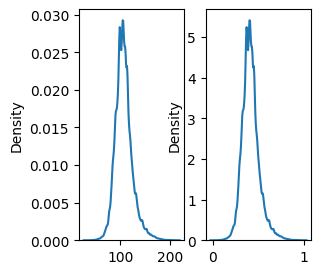

image min: 0.0 image max: 1.0
task-23-20230207_MeO_NPs_perov_1um.0_00005.spm_training.png


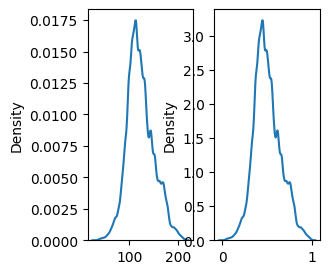

image min: 0.0 image max: 1.0
task-24-20230207_MeO_NPs_perov_5um.0_00003.spm_training.png


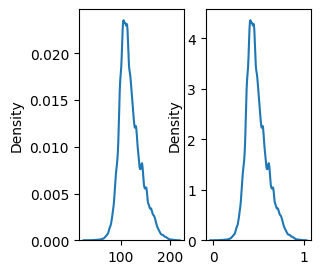

image min: 0.0 image max: 1.0
task-25-20230207_MeO_NPs_perov_10um.0_00004.spm_training.png


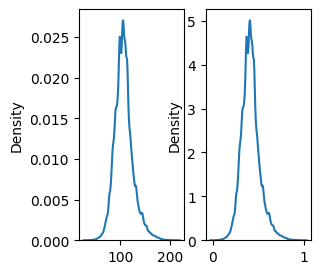

image min: 0.0 image max: 1.0
task-26-20230207_MeO_perov_1um.0_00002.spm_training.png


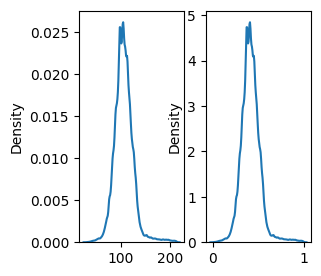

image min: 0.0 image max: 1.0
task-27-20230207_MeO_perov_5um.0_0000.spm_training.png


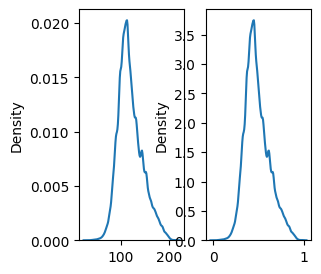

image min: 0.0 image max: 1.0
-- masks --
['task-20-annotation-21-by-1-tag-grain-0.png', 'task-21-annotation-44-by-1-tag-grain-0.png', 'task-22-annotation-47-by-1-tag-grain-0.png', 'task-23-annotation-22-by-1-tag-grain-0.png', 'task-24-annotation-45-by-1-tag-grain-0.png', 'task-25-annotation-48-by-1-tag-grain-0.png', 'task-26-annotation-23-by-1-tag-grain-0.png', 'task-27-annotation-46-by-1-tag-grain-0.png']
task-20-annotation-21-by-1-tag-grain-0.png
mask unique: [  0  16  31  32  36  46  48  51  55  60  61  63  64  79  80  91  95  96
  99 100 101 106 111 112 113 116 121 124 126 127 128 143 144 145 146 147
 159 160 164 166 168 175 176 177 178 184 186 191 192 193 195 196 199 200
 201 207 208 210 211 212 214 215 216 217 220 221 222 223 224 226 229 230
 232 235 238 239 240 243 245 247 248 249 251 252 253 254 255]
task-21-annotation-44-by-1-tag-grain-0.png
mask unique: [  0   6  11  12  16  18  20  21  23  26  27  31  32  42  43  46  48  51
  53  55  60  61  63  64  67  71  74  75  76  78  

In [63]:
IMAGE_DIR = Path('/Users/sylvi/topo_data/perovskite/dl_data/images')
MASK_DIR = Path('/Users/sylvi/topo_data/perovskite/dl_data/ground_truth')
MODEL_SAVE_DIR = Path('/Users/sylvi/topo_data/perovskite/saved_models/')
SIZE = 512
image_dataset = []
mask_dataset = []

print(' -- images --')

images = os.listdir(IMAGE_DIR)
images = sorted(images)
print(images)
for index, image_name in enumerate(images):
    print(image_name)
    if (image_name.split('.')[-1] == 'png'):
        image = cv2.imread(str(IMAGE_DIR / image_name), 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        fig, ax = plt.subplots(1, 2, figsize=(3, 3))
        sns.kdeplot(image.flatten(), ax=ax[0])
        image = image - np.min(image)
        image = image / np.max(image)
        sns.kdeplot(image.flatten(), ax=ax[1])
        plt.show()
        print(f'image min: {np.min(image)} image max: {np.max(image)}')
        image_flip_y = np.flip(image, axis=0)
        image_flip_x = np.flip(image, axis=1)
        image_flip_xy = np.flip(image_flip_y, 1)
        for im in [image, image_flip_y, image_flip_x, image_flip_xy]:
            image_dataset.append(im)
            image_dataset.append(cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE))
            image_dataset.append(cv2.rotate(im, cv2.ROTATE_180))
            image_dataset.append(cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE))

print('-- masks --')

masks = os.listdir(MASK_DIR)
masks = sorted(masks)
print(masks)
for index, image_name in enumerate(masks):
    print(image_name)
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(str(MASK_DIR / image_name), 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        print(f'mask unique: {np.unique(image)}')
        image_flip_y = np.flip(image, axis=0)
        image_flip_x = np.flip(image, axis=1)
        image_flip_xy = np.flip(image_flip_y, axis=1)
        for im in [image, image_flip_y, image_flip_x, image_flip_xy]:
            mask_dataset.append(im.astype(bool))
            mask_dataset.append(cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE).astype(bool))
            mask_dataset.append(cv2.rotate(im, cv2.ROTATE_180).astype(bool))
            mask_dataset.append(cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE).astype(bool))

# CLEAN UP
del(images, masks, image, im, image_name, index, image_flip_y, image_flip_x, image_flip_xy)

image dataset size: 128
mask dataset size: 128
index: 35


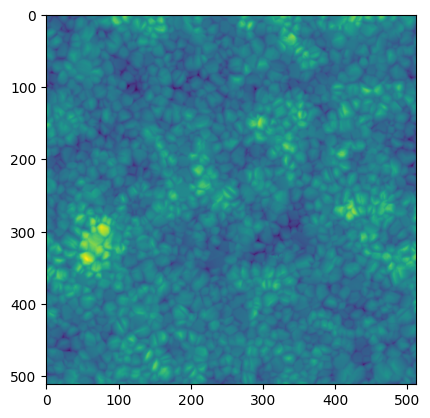

img dataset | min: 0.0 max: 1.0
(512, 512)


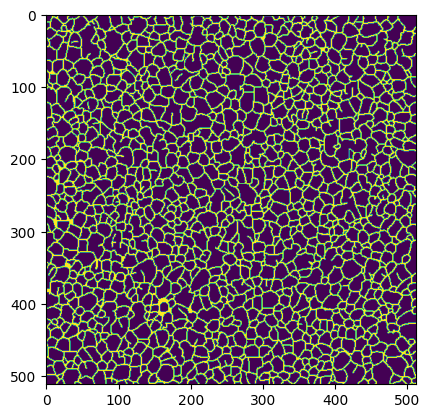

unique: [False  True]
shape: (512, 512)


In [64]:
# Check the data has been loaded correctly

print(f'image dataset size: {len(image_dataset)}')
print(f'mask dataset size: {len(mask_dataset)}')

index = np.random.randint(0, len(image_dataset)-1)
print(f'index: {index}')

plt.imshow(image_dataset[index])
plt.show()
print(f'img dataset | min: {np.min(image_dataset)} max: {np.max(image_dataset)}')
print(np.shape(image_dataset[index]))

plt.imshow(mask_dataset[index])
plt.show()
print(f'unique: {np.unique(mask_dataset[index])}')
print(f'shape: {np.shape(mask_dataset[index])}')

In [65]:
# DO NOT RUN MORE THAN ONCE

# Expand dims because the model doesn't work unless we add an extra dimension, don't know why.
image_dataset = np.expand_dims(np.array(image_dataset), 3)
mask_dataset = np.expand_dims(np.array(mask_dataset),3)

print(image_dataset.shape)
print(mask_dataset.shape)
print(f'image dataset min, max: {np.min(image_dataset), np.max(image_dataset)}')
print(f'mask unique values: {np.unique(mask_dataset)}')

(128, 512, 512, 1)
(128, 512, 512, 1)
image dataset min, max: (0.0, 1.0)
mask unique values: [False  True]


In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=0)

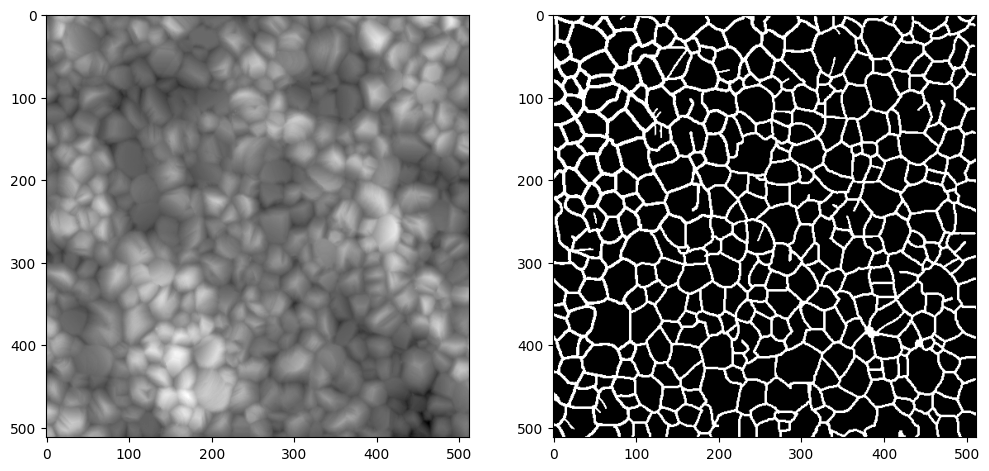

In [67]:
# Check things are working correctly
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.show()

In [68]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
# Optionally LOAD the model
# model.load_weights('mitochondria_test.hdf5')

In [74]:
# Train the model
BATCH_SIZE = 4
EPOCHS = 50
history = model.fit(
    X_train,
    y_train,
    batch_size=4,
    verbose=1,
    epochs=50,
    validation_data=(X_test, y_test),
    shuffle=False
)

# SAVE THE MODEL WITH DATE AND PARAMS IN THE NAME
now = datetime.now()
dt_string = str(now.strftime("%Y%m%d_%H-%M-%S"))
filename = str(MODEL_SAVE_DIR / f'{dt_string}_perovskite_s{SIZE}_b{BATCH_SIZE}_e{EPOCHS}.hdf5')
print(f'saving file: {filename}')
model.save(filename)

Epoch 1/50


2023-04-26 16:42:33.357091: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-26 16:42:33.871262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7763

2023-04-26 16:42:48.030402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 15s 491ms/step - loss: 0.5043 - accuracy: 0.7763 - val_loss: 0.4578 - val_accuracy: 0.8105
Epoch 2/50
29/29 [==============================] - 13s 463ms/step - loss: 0.4759 - accuracy: 0.7920 - val_loss: 0.4349 - val_accuracy: 0.8105
Epoch 3/50
29/29 [==============================] - 13s 461ms/step - loss: 0.4339 - accuracy: 0.8023 - val_loss: 0.3667 - val_accuracy: 0.8341
Epoch 4/50
29/29 [==============================] - 13s 463ms/step - loss: 0.3813 - accuracy: 0.8281 - val_loss: 0.3394 - val_accuracy: 0.8452
Epoch 5/50
29/29 [==============================] - 13s 464ms/step - loss: 0.3572 - accuracy: 0.8371 - val_loss: 0.3248 - val_accuracy: 0.8506
Epoch 6/50
29/29 [==============================] - 13s 463ms/step - loss: 0.3362 - accuracy: 0.8483 - val_loss: 0.3010 - val_accuracy: 0.8639
Epoch 7/50
29/29 [==============================] - 13s 465ms/step - loss: 0.3158 - accuracy: 0.8584 - val_loss: 0.2930 - val_accuracy: 0.8612
Epoch 8/50

## Load model

In [23]:
# # LOAD MODEL
# import tensorflow as tf

# model = tf.keras.models.load_model('./20230424_16-11-49_perovskite_512_b4_e50.hdf5')
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [75]:
# Check model accuracy
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 385ms/step - loss: 0.2114 - accuracy: 0.9166
Accuracy =  91.65526032447815 %


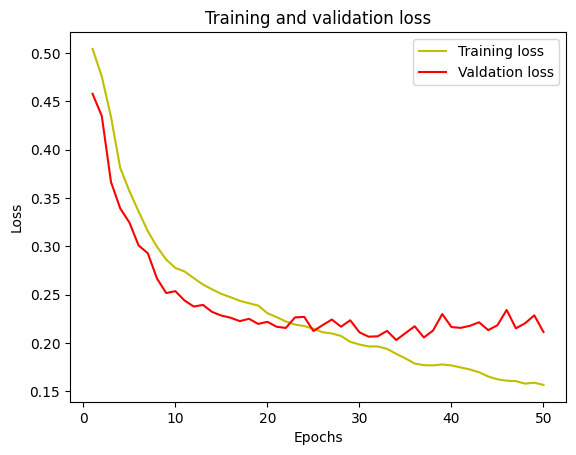

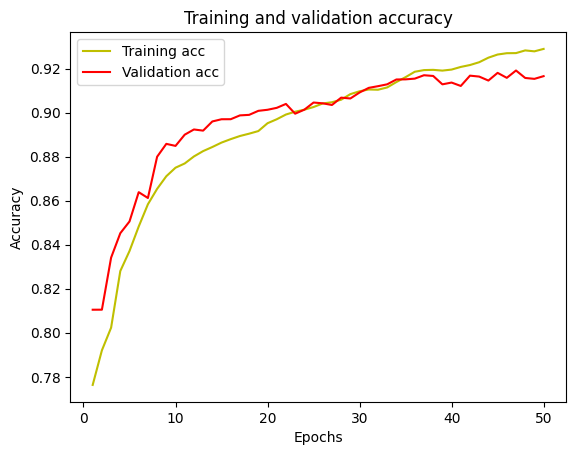

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Valdation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [85]:
# Note that for semantic segmentation, accuracy is not the correct metric.

# Calculate IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5 # this value is a probability cutoff

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print(f"IoU score: {iou_score}")

1/1 [==============================] - 0s 17ms/step
IoU score: 0.6464916805996681


test image number: 0 / 13
ground truth shape: (512, 512)
1/1 [==============================] - 0s 15ms/step


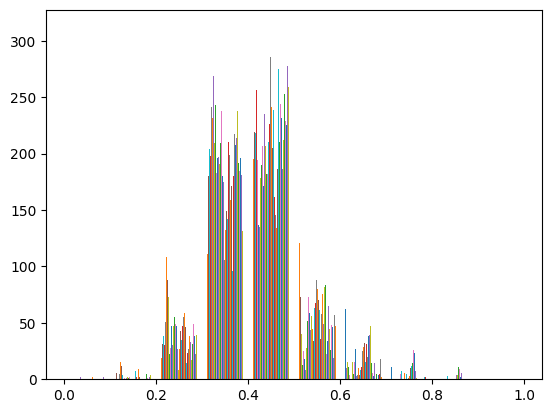

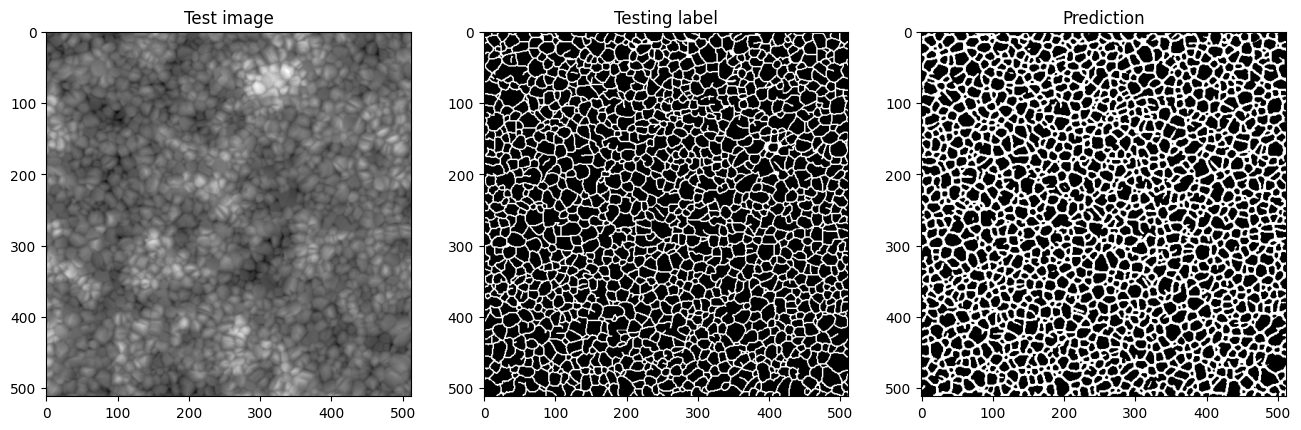

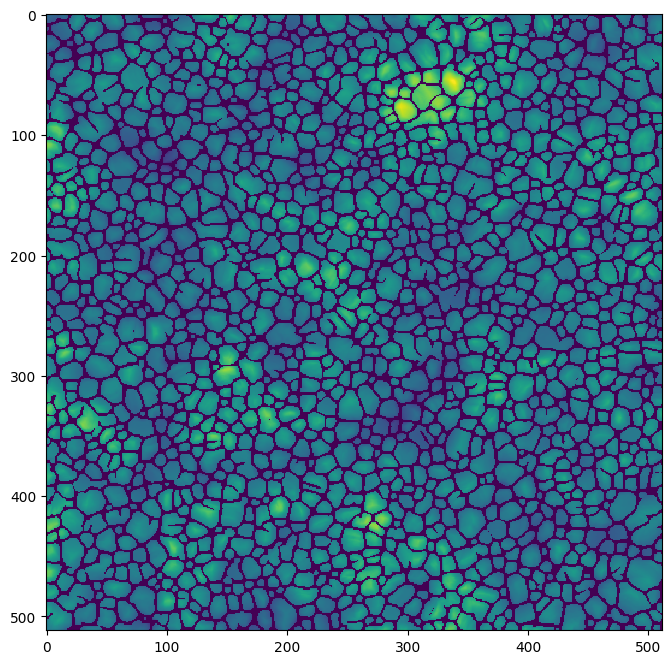

prediction shape: (512, 512)


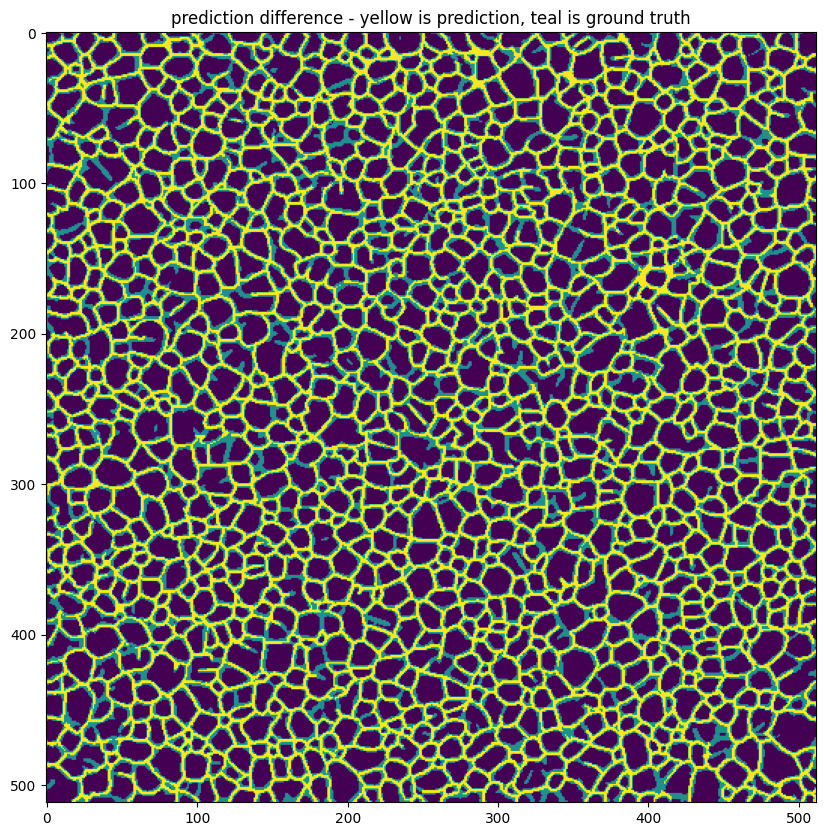

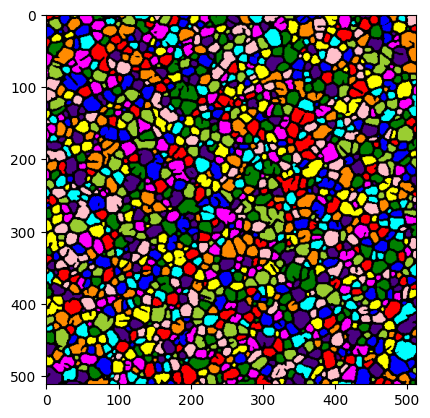

In [88]:
# See how it predicts our testing dataset

threshold = 0.2

test_img_number = random.randint(0, len(X_test)-1)
print(f'test image number: {test_img_number} / {len(X_test)}')
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
ground_truth = ground_truth.reshape(512, 512)
print(f'ground truth shape: {ground_truth.shape}')
test_img_norm=test_img[:, :, 0][:, :, None]
plt.hist(test_img_norm[:, :, 0])
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0, :, :, 0] > threshold).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Test image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(ground_truth, cmap='gray')
plt.title('Testing label')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title('Prediction')
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_img)
ax.imshow(np.ma.masked_where(prediction == 0, prediction))
plt.show()

prediction = prediction == 0
print(f'prediction shape: {prediction.shape}')
difference = ground_truth.astype(int) - prediction.astype(int)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(difference)
ax.set_title('prediction difference - yellow is prediction, teal is ground truth')
plt.show()

labelled = label(prediction)
coloured = label2rgb(labelled)
plt.imshow(coloured)

[Wed, 26 Apr 2023 18:20:32] [INFO    ] [topostats] Extracting image from /Users/sylvi/topo_data/perovskite/perovskite_images/3cat/3cat_3um_1024.0_00002.spm
[Wed, 26 Apr 2023 18:20:32] [INFO    ] [topostats] Loading image from : /Users/sylvi/topo_data/perovskite/perovskite_images/3cat/3cat_3um_1024.0_00002.spm
[Wed, 26 Apr 2023 18:20:32] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Loaded image from : /Users/sylvi/topo_data/perovskite/perovskite_images/3cat/3cat_3um_1024.0_00002.spm
[Wed, 26 Apr 2023 18:20:32] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Extracted channel Height
[Wed, 26 Apr 2023 18:20:32] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Pixel to nm scaling : 2.9296875
[Wed, 26 Apr 2023 18:20:32] [INFO    ] [topostats] Loading image from : /Users/sylvi/topo_data/perovskite/perovskite_images/3cat/3cat_3um_1024.0_00002.spm
[Wed, 26 Apr 2023 18:20:32] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Loaded image from : /Users/sylvi/topo_data/perovskite/perovskite_i

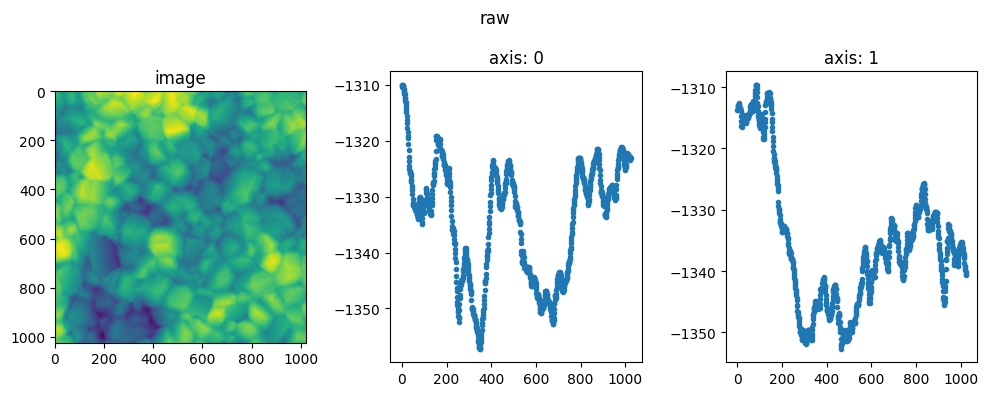

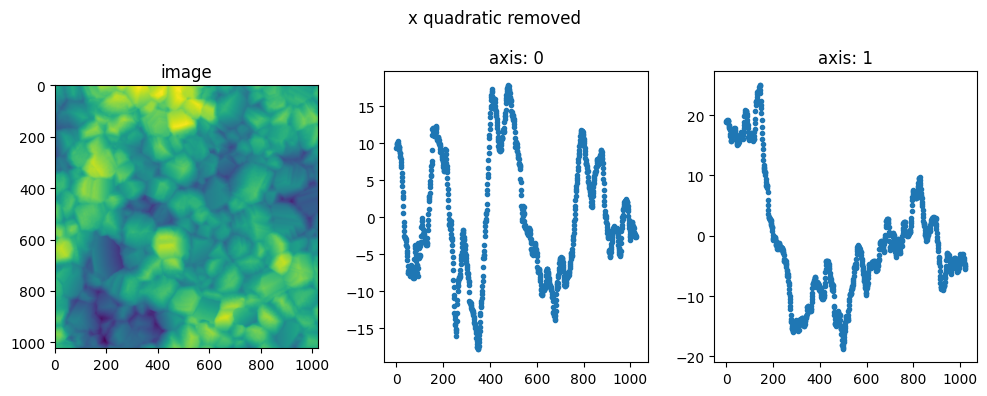

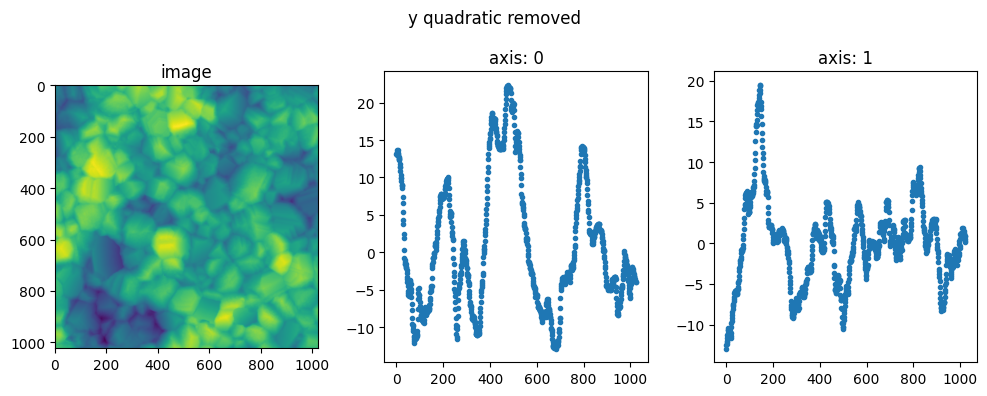

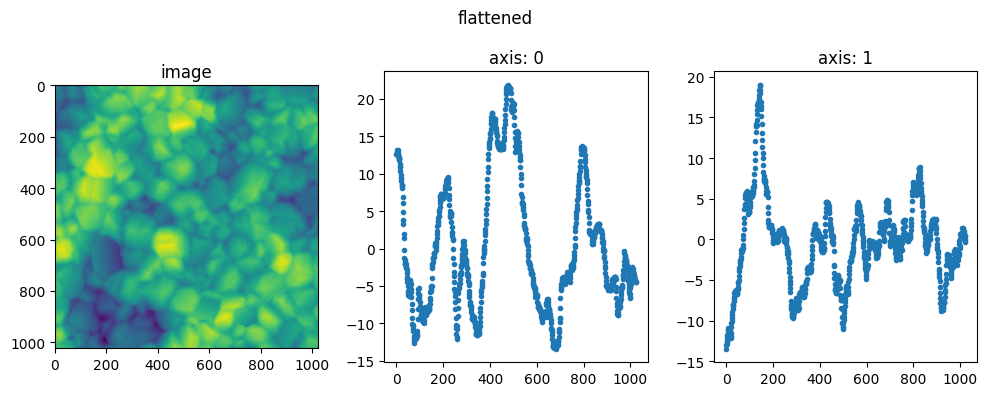

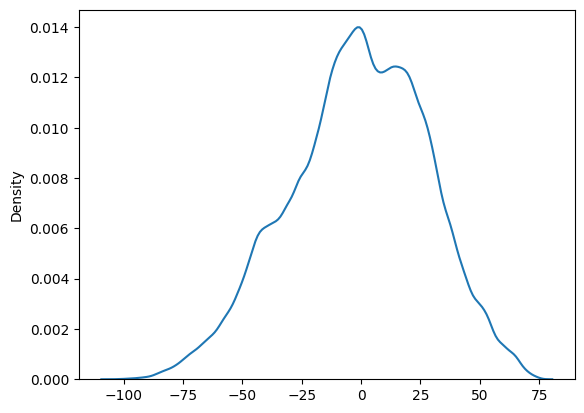

min: -103.93062474066069 max: 75.05626426951991
min: 0.0 max: 1.0


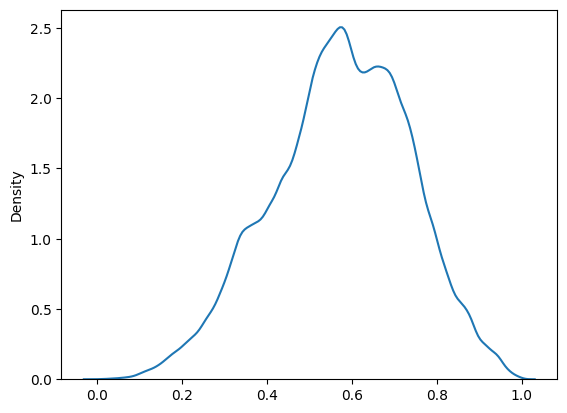

image shape: (1024, 1024)
min, max values: (0.0, 1.0)
[0.         0.00262067 0.00450483 ... 0.99894633 0.99937293 1.        ]
image shape: (512, 512)
to predict shape: (1, 512, 512)
to predict shape: (1, 512, 512, 1)
to predict shape: (1, 512, 512, 1)
1/1 [==============================] - 0s 14ms/step
prediction unique vals: [0 1]


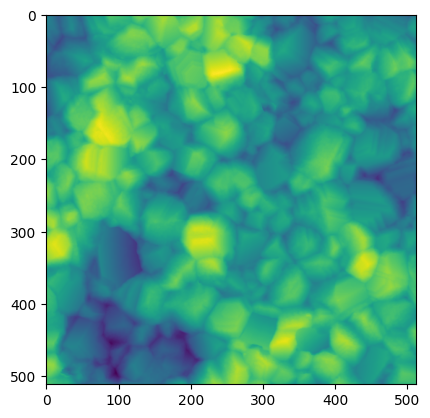

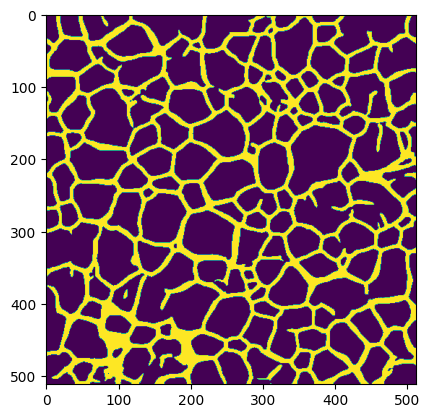

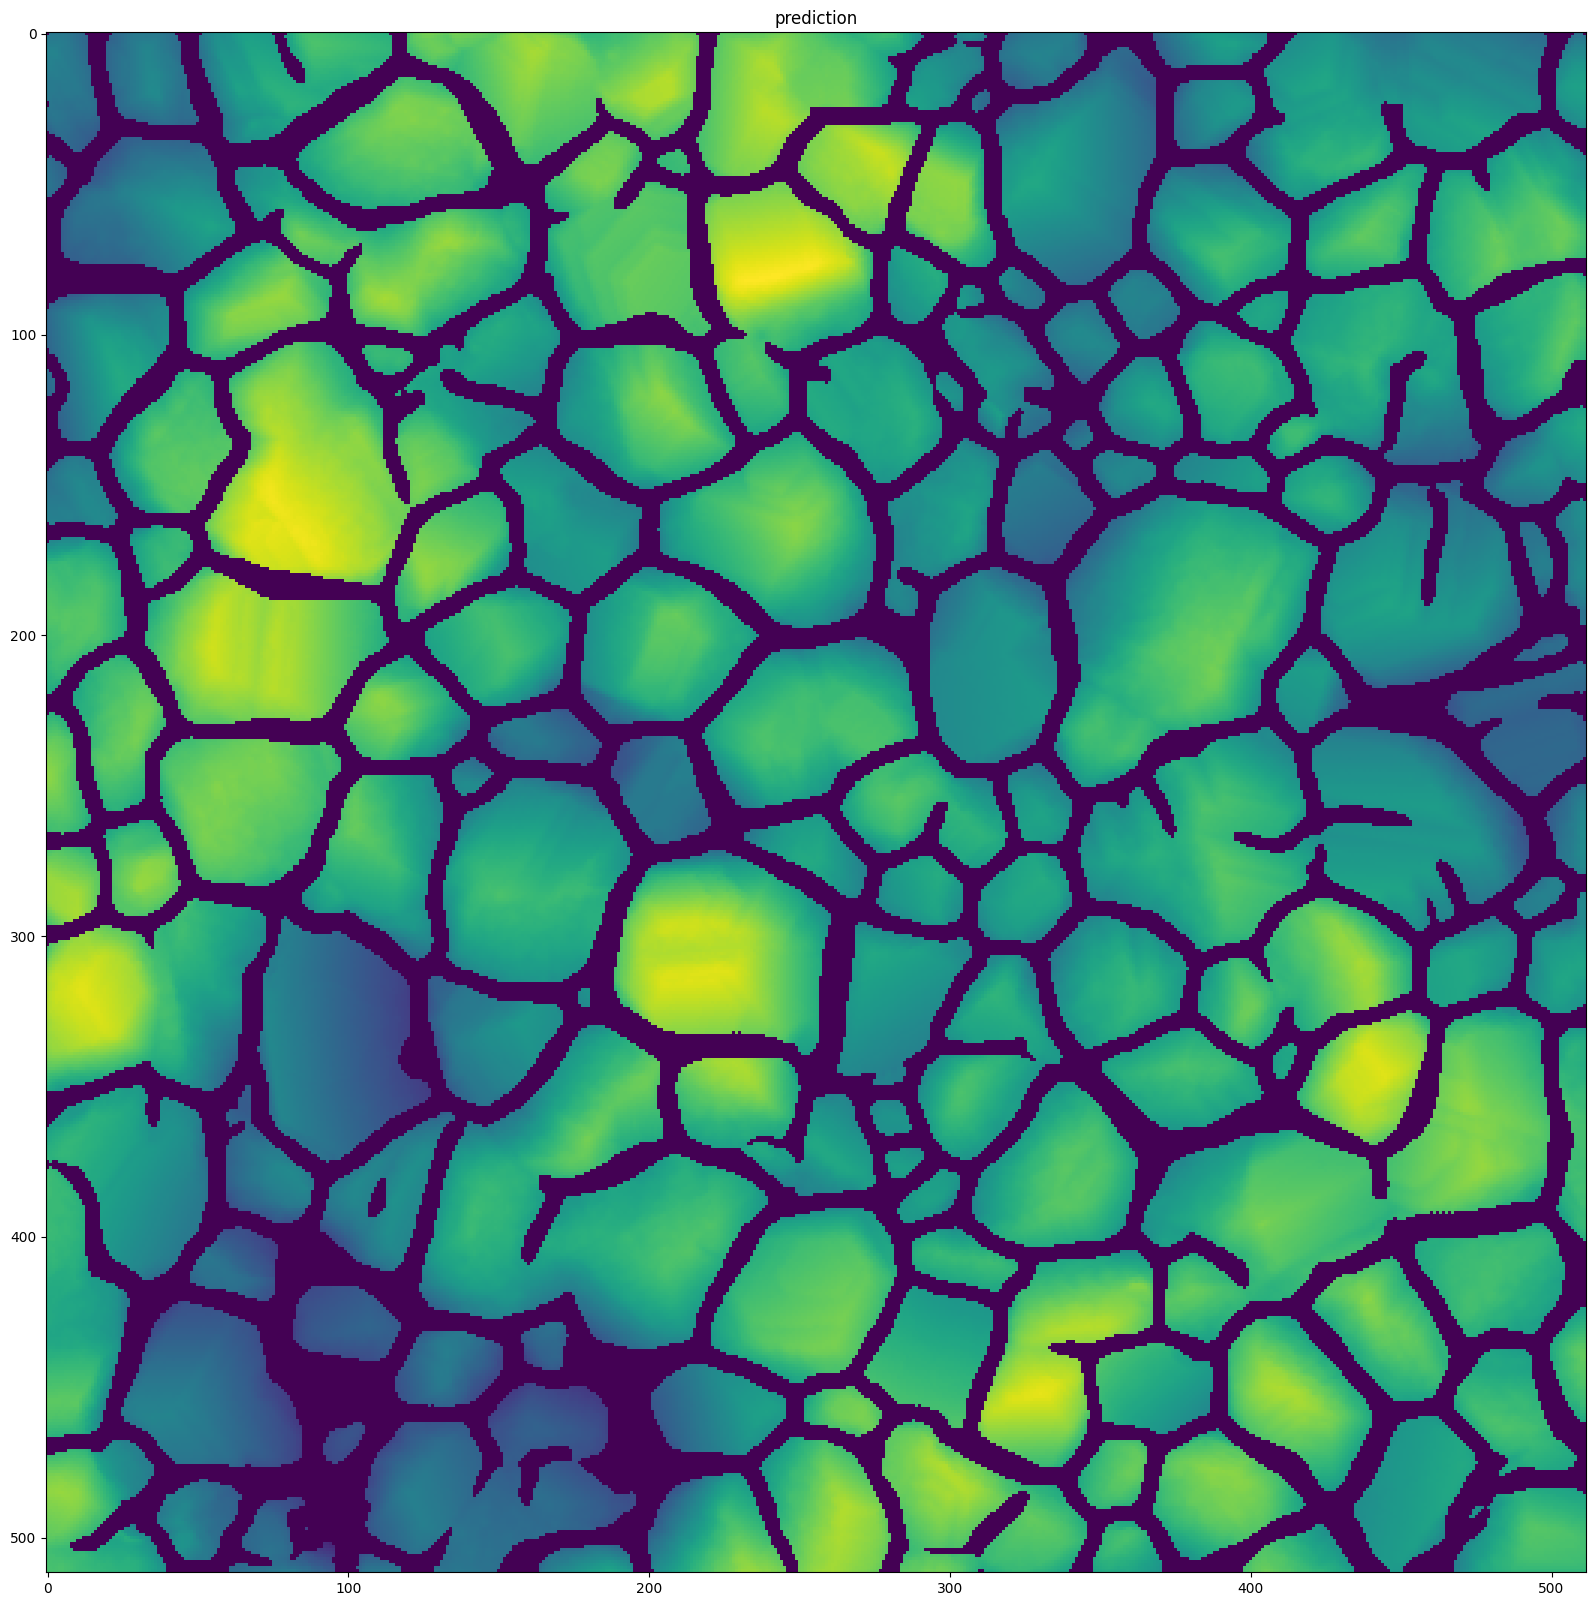

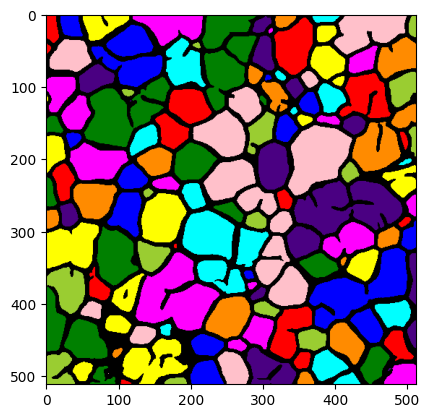

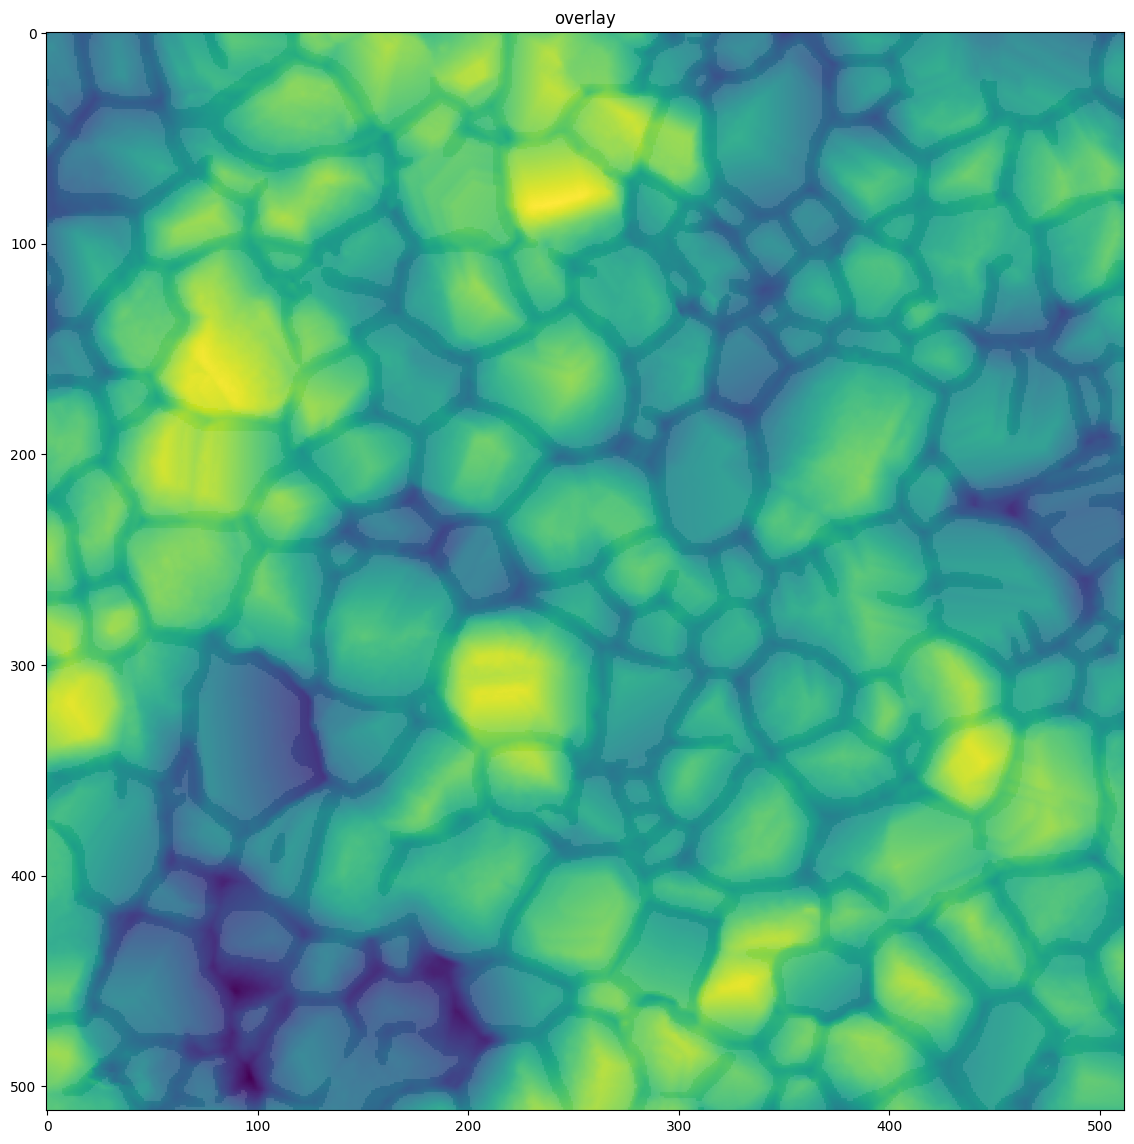

unique skeleton prediction: [False  True]


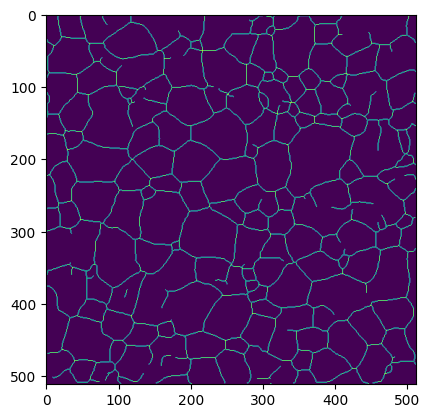

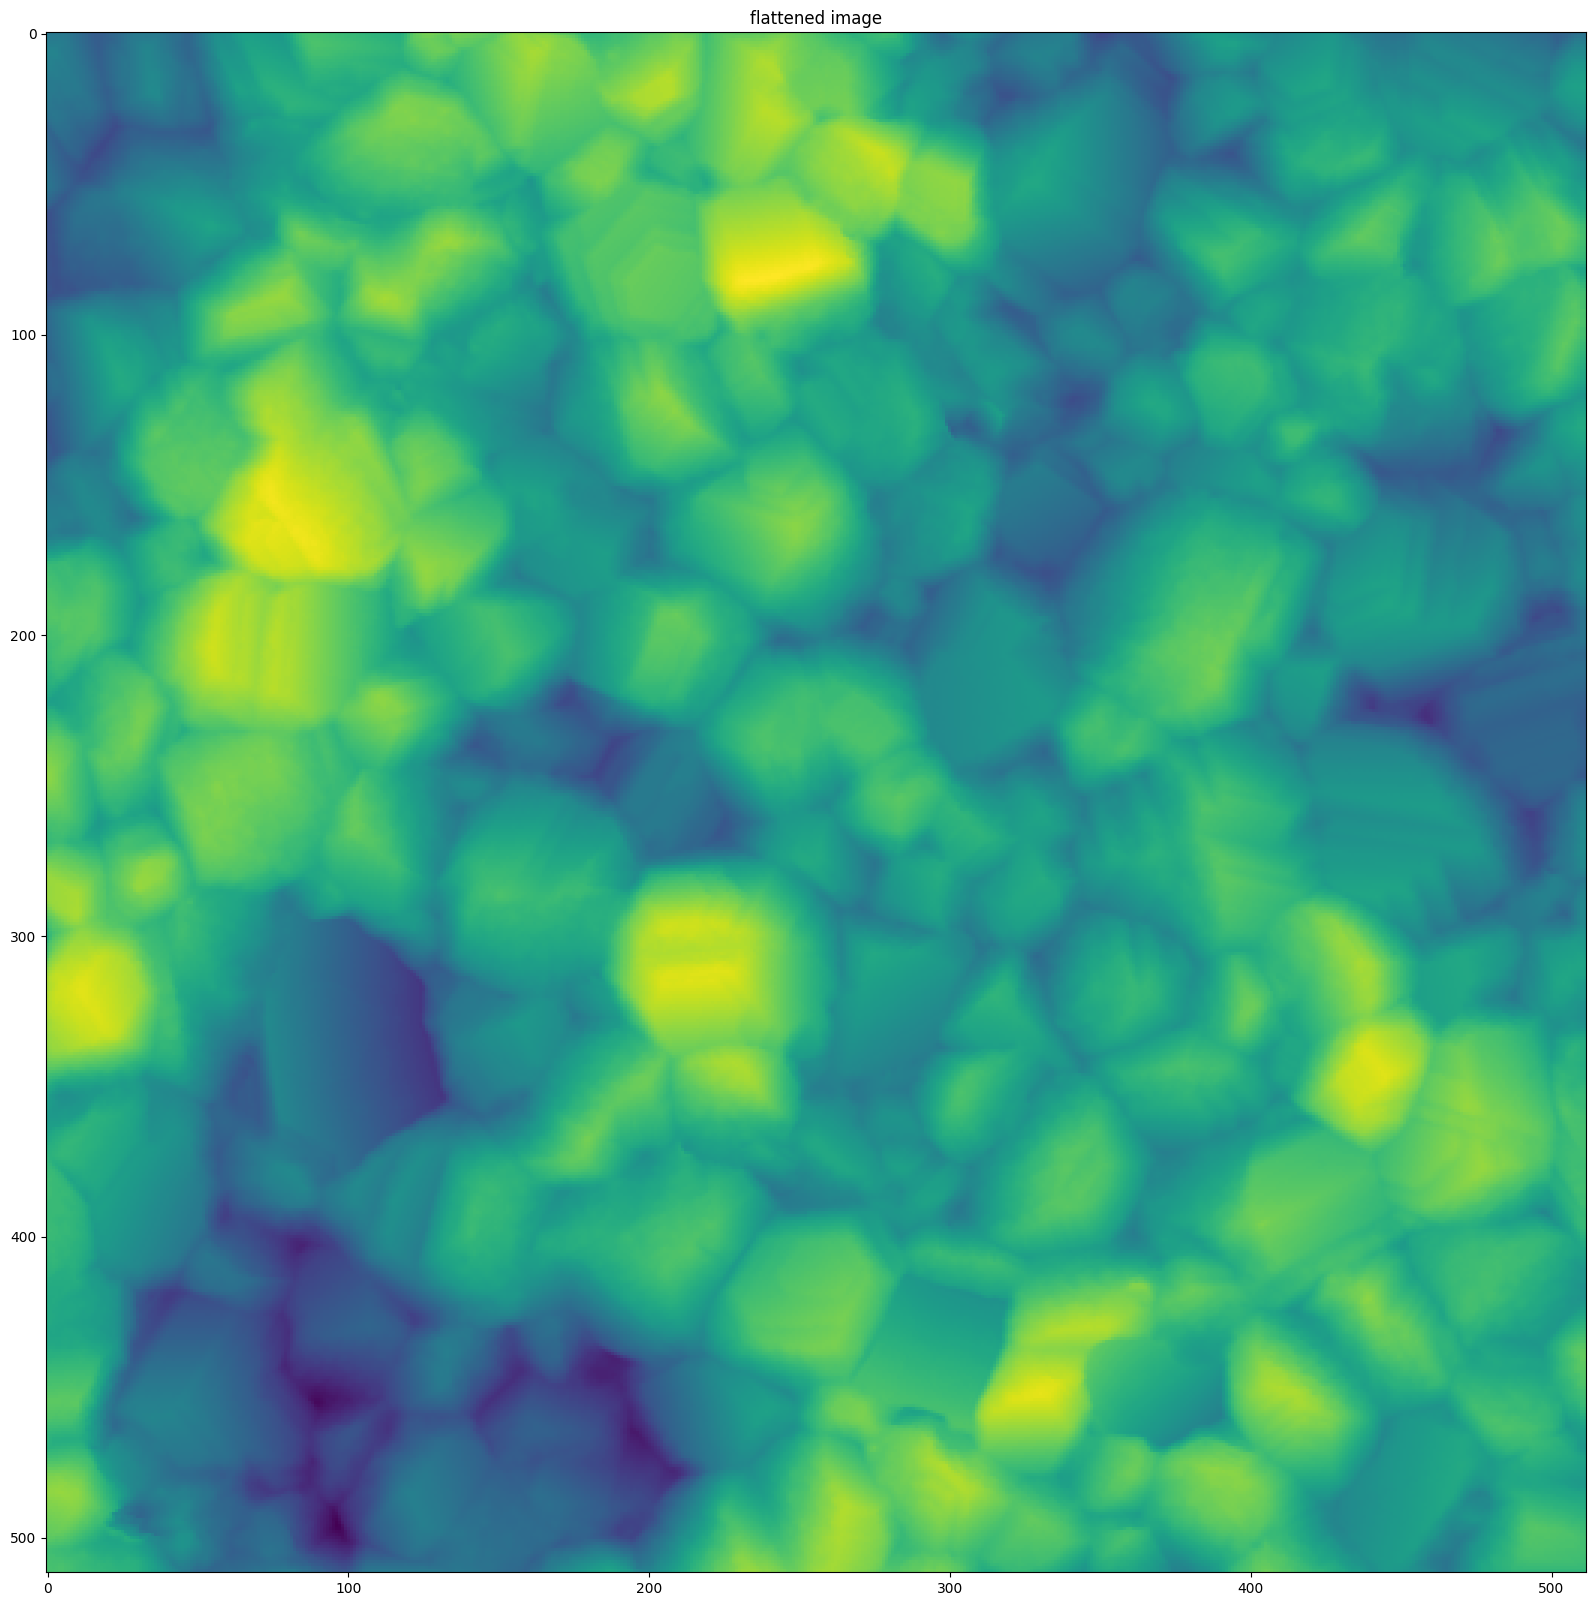

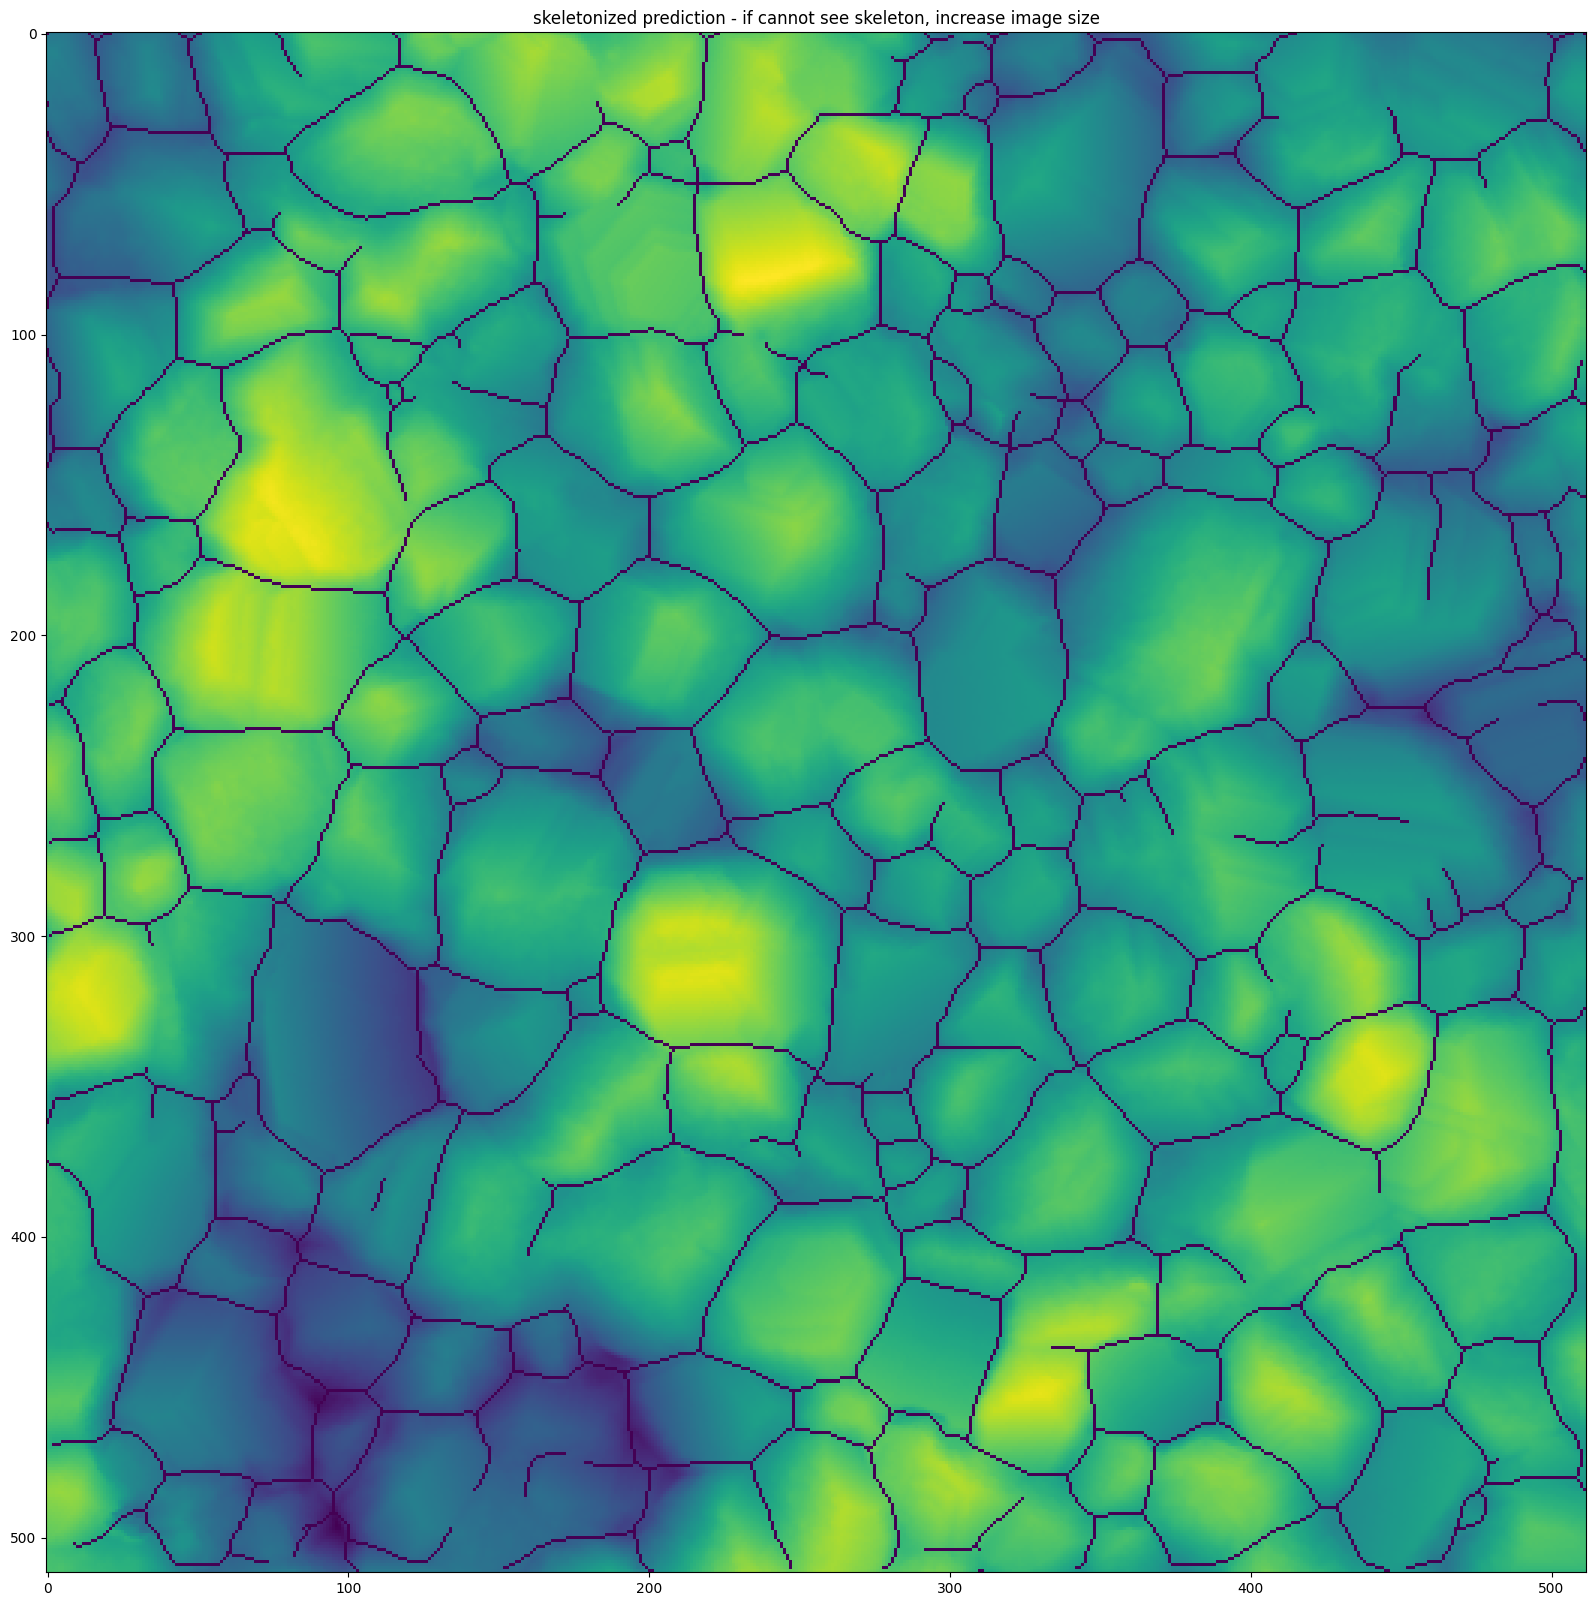

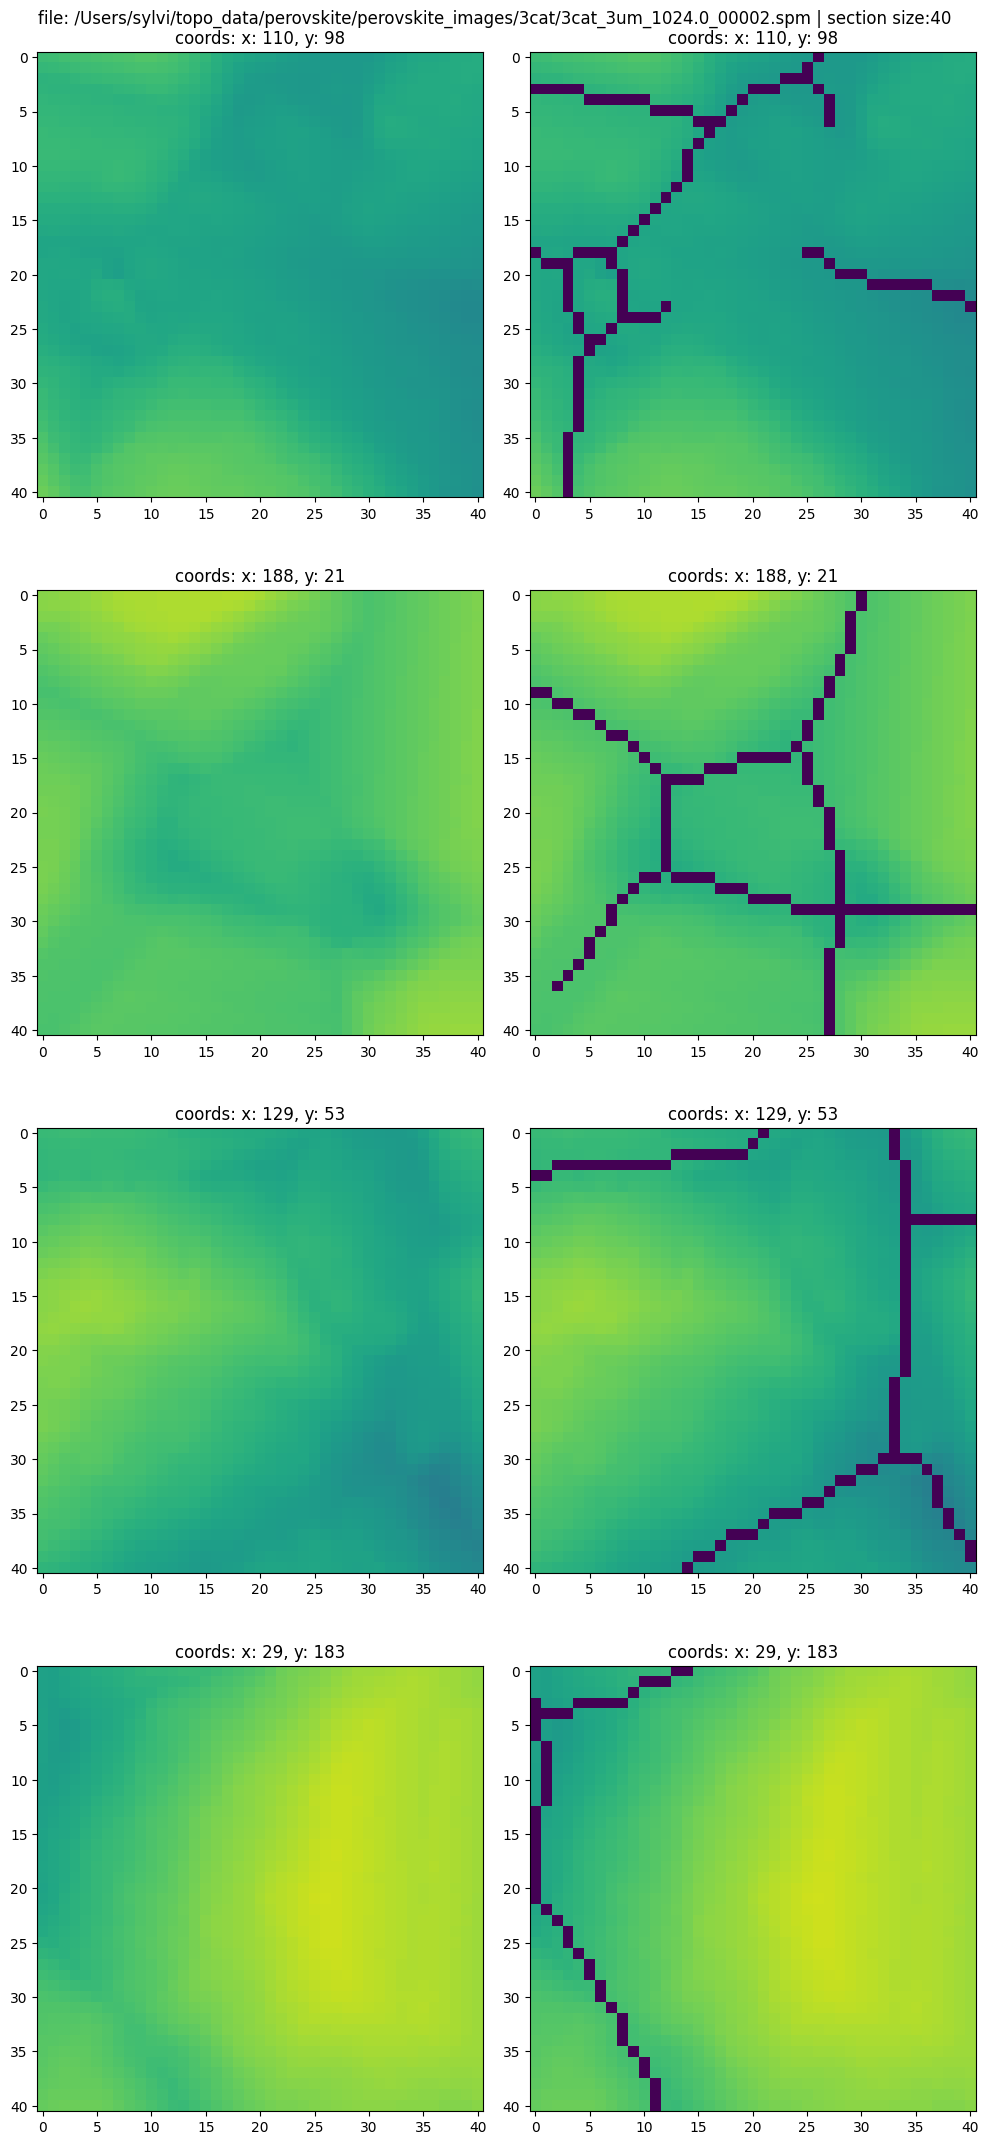

In [126]:
# Try a completely new image

# FROM PNG
# another_image_file = './dl_data/to_be_labelled/20230207_MeO_perov_10um.0_00001.png'
# image = cv2.imread(another_image_file, 0)
# print(f'original shape: {np.sqrt(image.size)}')

# FROM SPM
another_image_file = Path('/Users/sylvi/topo_data/perovskite/perovskite_images/3cat/3cat_3um_1024.0_00002.spm')
from topostats import io
# loadscan = io.LoadScans(img_paths = [file], channel='ZSensorRetrace')
loadscan = io.LoadScans(img_paths = [another_image_file], channel='Height')
loadscan.get_data()
# data, pixel_to_nm = loadscan.load_ibw()
image, pixel_to_nm = loadscan.load_spm()

image = perov_flatten.flatten_image(image, order=3, plot_steps=True)

# Normalize image
sns.kdeplot(image.flatten())
plt.show()
print(f'min: {np.min(image)} max: {np.max(image)}')
image = image - np.min(image)
image = image / np.max(image)
# image = image - np.min(image)
# print(f'min: {np.min(image)} max: {np.max(image)}')
# image = normalize(image)
# image = image / np.max(image)
print(f'min: {np.min(image)} max: {np.max(image)}')
sns.kdeplot(image.flatten())
plt.show()

# Resize image to the correct size
print(f'image shape: {image.shape}')
print(f'min, max values: {np.min(image), np.max(image)}')
print(np.unique(image))
image =  Image.fromarray(image)
image = image.resize((SIZE, SIZE))
image = np.array(image)
print(f'image shape: {image.shape}')

# Get the input image into the right form (since training was in A x 512 x 512 x 1 shape)
# This was just trial and error, I don't really have a good understanding of this bit
to_predict = [image]
to_predict = np.array(to_predict)
print(f'to predict shape: {to_predict.shape}')
to_predict = np.expand_dims(to_predict, 3)
print(f'to predict shape: {to_predict.shape}')
# Fetch image from the strange array
test_img = to_predict[0]
test_img = test_img[:, :, 0][:, :, None]
test_img = np.expand_dims(test_img, 0)
print(f'to predict shape: {test_img.shape}')

# Get prediction
prediction = (model.predict(test_img)[0, :, :, 0] > 0.1).astype(np.uint8)
print(f'prediction unique vals: {np.unique(prediction)}')
# prediction = skeletonize(prediction)
plt.imshow(image)
plt.show()
plt.imshow(prediction)
plt.show()

# Pot prediction
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image)
masked = np.ma.masked_where(prediction.astype(int) == 0, prediction)
ax.imshow(masked)
ax.set_title('prediction')
plt.show()

labelled = label(prediction == 0, connectivity=1)
coloured = label2rgb(labelled)
fig, ax = plt.subplots()
ax.imshow(coloured)
plt.show()

fig, ax = plt.subplots(figsize=(14, 14))
test_mask = np.zeros(image.shape)
for j in range(coloured.shape[0]):
    for i in range(coloured.shape[1]):
        if np.array_equal(coloured[j, i], np.array([0, 0, 0])):
            test_mask[j, i] = 1


overlay = np.zeros(image.shape)

test_masked = np.ma.masked_where(test_mask == 1, overlay)
ax.imshow(image)
ax.imshow(test_masked, alpha=0.1, cmap='binary')
ax.set_title('overlay')
plt.show()

# Plot skeletonised segmentation
skeleton_prediction = skeletonize(prediction)
print(f'unique skeleton prediction: {np.unique(skeleton_prediction)}')
plt.imshow(skeleton_prediction)
plt.show()

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image)
ax.set_title('flattened image')
plt.show()

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image)
masked = np.ma.masked_where(skeleton_prediction == 0, skeleton_prediction.astype(int))
ax.imshow(masked)
plt.title('skeletonized prediction - if cannot see skeleton, increase image size')
plt.show()

fig, ax = plt.subplots(4, 2, figsize=(10, 22))
section_size = 40
vmin = np.min(image)
vmax = np.max(image)
for index in range(ax.shape[0]):
    y = np.random.randint(0, image.shape[0]-section_size)
    x = np.random.randint(0, image.shape[1]-section_size)
    img_section = image[y:y+section_size+1, x:x+section_size+1]
    mask_section = masked[y:y+section_size+1, x:x+section_size+1]
    ax[index, 0].imshow(img_section, vmin=vmin, vmax=vmax)
    ax[index, 1].imshow(img_section, vmin=vmin, vmax=vmax)
    ax[index, 1].imshow(mask_section)
    ax[index, 0].set_title(f'coords: x: {x}, y: {y}')
    ax[index, 1].set_title(f'coords: x: {x}, y: {y}')
fig.suptitle(f'file: {another_image_file} | section size:{section_size}')
fig.tight_layout()


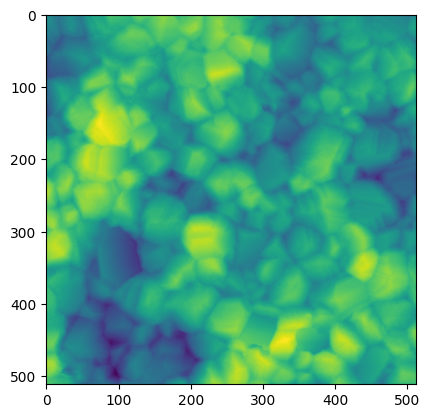

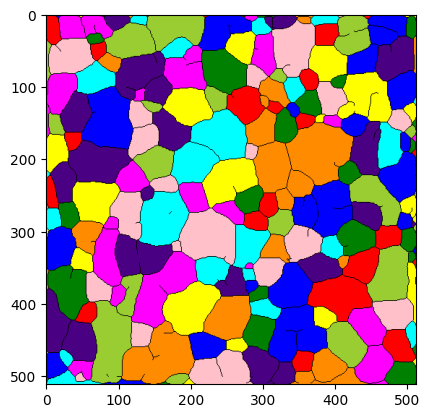

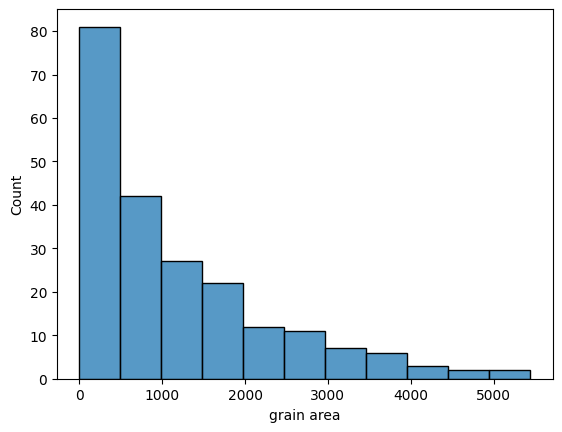

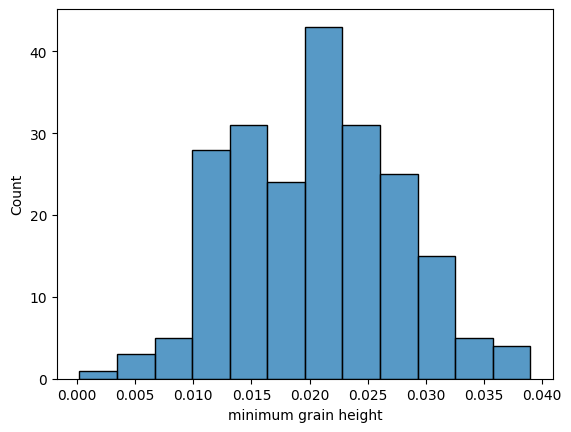

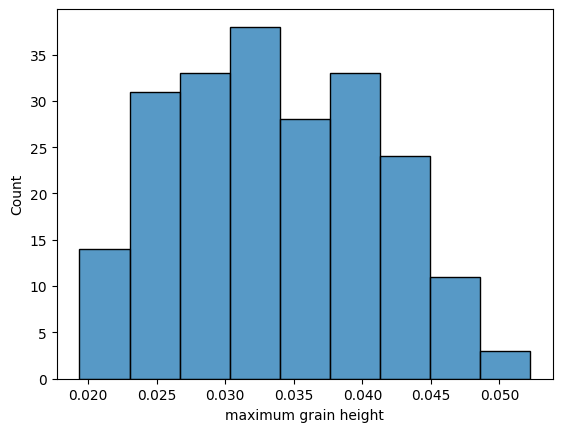

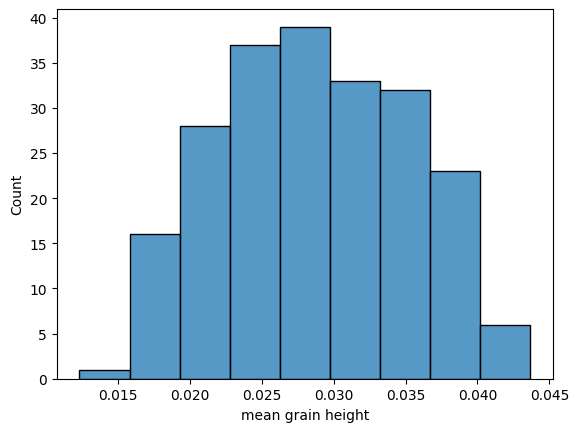

mean grain area: 1162.7488372093023
mean mean grain height: 0.028749652206897736
number of grains: 215


In [39]:
# Grain stats

areas = []
mean_heights = []
max_heights = []
min_heights = []

region_props = regionprops(labelled)
for index, props in enumerate(region_props):
    if props.label == 0:
        pass
    else:
        areas.append(props.area)
        heights = image[labelled == props.label]
        mean_heights.append(np.mean(heights))
        min_heights.append(np.min(heights))
        max_heights.append(np.max(heights))

plt.imshow(image)
plt.show()
plt.imshow(coloured)
plt.show()

ax = sns.histplot(areas)
ax.set_xlabel('grain area')
plt.show()

ax = sns.histplot(min_heights)
ax.set_xlabel('minimum grain height')
plt.show()

ax = sns.histplot(max_heights)
ax.set_xlabel('maximum grain height')
plt.show()

ax = sns.histplot(mean_heights)
ax.set_xlabel('mean grain height')
plt.show()

print(f'mean grain area: {np.mean(areas)}')
print(f'mean mean grain height: {np.mean(mean_heights)}')
print(f'number of grains: {len(areas)}')